In [217]:
import numpy as np
import pandas as pd
from nsetools import Nse
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense ,Dropout ,LSTM , LeakyReLU,BatchNormalization
from keras.models import Sequential
from sklearn.metrics import r2_score
import pickle
plt.style.use('fivethirtyeight')

In [526]:
import yfinance as yf
import datetime
# Fetch the components of the Nifty 50 index
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime.today()

ticker = "^NSEI"  # Ticker symbol for the Nifty index
data = yf.download(ticker, start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed


In [527]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-22,18853.599609,18886.599609,18759.500000,18771.250000,18771.250000,252700
2023-06-23,18741.849609,18756.400391,18647.099609,18665.500000,18665.500000,210600
2023-06-26,18682.349609,18722.050781,18646.699219,18691.199219,18691.199219,171300
2023-06-27,18748.550781,18829.250000,18714.250000,18817.400391,18817.400391,222500
2023-06-30,19076.849609,19201.699219,19024.599609,19189.050781,19189.050781,247900


In [213]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3310 entries, 2010-01-04 to 2023-06-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3310 non-null   float64
 1   High       3310 non-null   float64
 2   Low        3310 non-null   float64
 3   Close      3310 non-null   float64
 4   Adj Close  3310 non-null   float64
 5   Volume     3310 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 181.0 KB


In [4]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-22,18853.599609,18886.599609,18759.500000,18771.250000,18771.250000,252700
2023-06-23,18741.849609,18756.400391,18647.099609,18665.500000,18665.500000,210600
2023-06-26,18682.349609,18722.050781,18646.699219,18691.199219,18691.199219,171300
2023-06-27,18748.550781,18829.250000,18714.250000,18817.400391,18817.400391,222500
2023-06-30,19076.849609,19201.699219,19024.599609,19189.050781,19189.050781,247900


In [5]:
data.shape

(3310, 6)

In [216]:
data.Close[:10]

Date
2010-01-04    5232.200195
2010-01-05    5277.899902
2010-01-06    5281.799805
2010-01-07    5263.100098
2010-01-08    5244.750000
2010-01-11    5249.399902
2010-01-12    5210.399902
2010-01-13    5233.950195
2010-01-14    5259.899902
2010-01-15    5252.200195
Name: Close, dtype: float64

In [7]:
# data.drop(['Date','Adj Close'],axis=1)

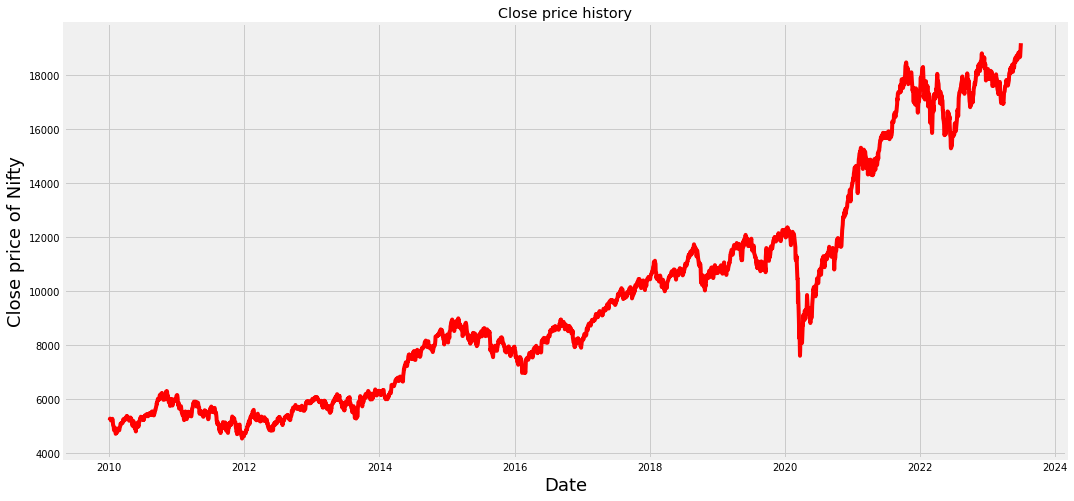

In [8]:
plt.figure(figsize=(16,8))
plt.title('Close price history')
plt.plot(data["Close"],'r')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close price of Nifty',fontsize=18)
plt.show()

In [9]:
ma100 = data.Close.rolling(100).mean() #calculates the moving average of the Closing price based on the pass 100 days
ma100

Date
2010-01-04             NaN
2010-01-05             NaN
2010-01-06             NaN
2010-01-07             NaN
2010-01-08             NaN
                  ...     
2023-06-22    17900.940527
2023-06-23    17908.676035
2023-06-26    17919.544531
2023-06-27    17931.229043
2023-06-30    17946.498047
Name: Close, Length: 3310, dtype: float64

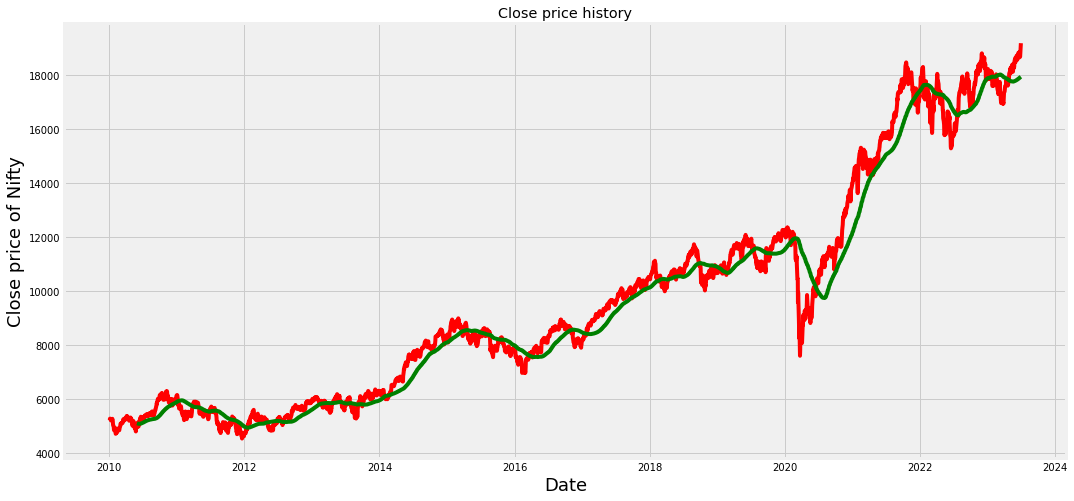

In [10]:
plt.figure(figsize=(16,8))
plt.title('Close price history')
plt.plot(data["Close"],'r')
plt.plot(ma100,'g')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close price of Nifty',fontsize=18)
plt.show()

In [11]:
ma200 = data.Close.rolling(200).mean()
ma200

Date
2010-01-04             NaN
2010-01-05             NaN
2010-01-06             NaN
2010-01-07             NaN
2010-01-08             NaN
                  ...     
2023-06-22    17924.076260
2023-06-23    17929.706514
2023-06-26    17934.833506
2023-06-27    17940.642510
2023-06-30    17948.465762
Name: Close, Length: 3310, dtype: float64

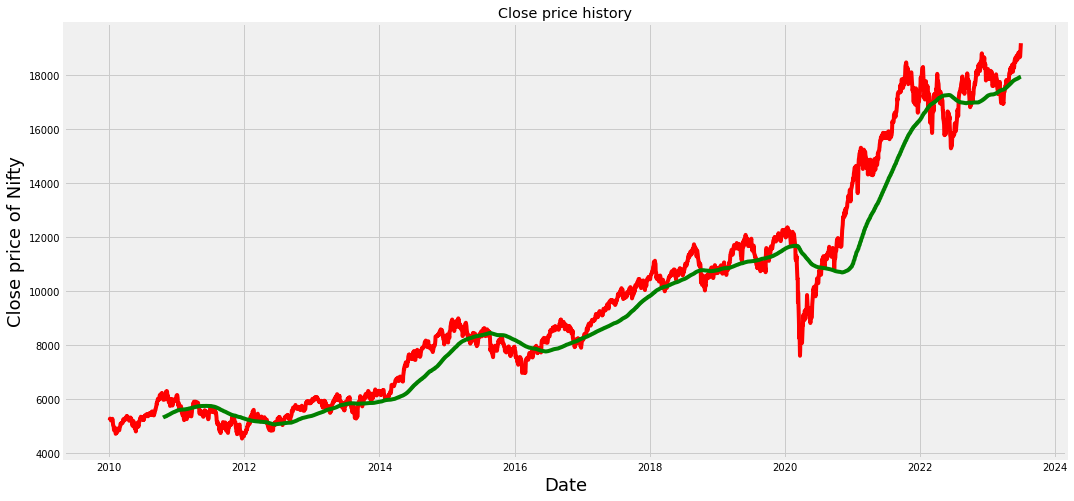

In [12]:
plt.figure(figsize=(16,8))
plt.title('Close price history')
plt.plot(data["Close"],'r')
plt.plot(ma200,'g')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close price of Nifty',fontsize=18)
plt.show()

In [81]:
# we will predict market trend using 'Close' values
close=data.filter(['Close'])
close.tail()

,Close
Date,
2023-06-22,18771.250000
2023-06-23,18665.500000
2023-06-26,18691.199219
2023-06-27,18817.400391
2023-06-30,19189.050781


In [82]:
dataset=close.values

In [83]:
dataset

array([[ 5232.20019531],
       [ 5277.89990234],
       [ 5281.79980469],
       ...,
       [18691.19921875],
       [18817.40039062],
       [19189.05078125]])

In [84]:
# Splitting the data ( we cannot do random splitting here as it is a time series data)
split_point=int(len(close)*0.8)

train_data=dataset[:split_point,:]
test_data=dataset[split_point:,:]

train_data.shape , test_data.shape



((2648, 1), (662, 1))

In [85]:
# train_data.tail()

In [86]:
# test_data.head()

In [306]:
# Scaling (Min-Max Scaler = Normalization)
min_value = 0  # Minimum value for scaling
max_value = 1 
scaler = MinMaxScaler(feature_range=(min_value,max_value))
train_data_array=scaler.fit_transform(train_data)
# Load the scaler object from the file
with open('scaler2.pkl', 'wb') as f:
    pickle.dump(scaler,f)
train_data_array

array([[0.08800093],
       [0.0938463 ],
       [0.09434513],
       ...,
       [0.94041396],
       [0.94474998],
       [0.92395213]])

In [307]:
x_train=[]
y_train=[]

for i in range(100,train_data_array.shape[0]):
    
    x_train.append(train_data_array[i-100:i])
    y_train.append(train_data_array[i,0])

    # if(i<=100):
    #     print(x_train)
    #     print("  Space   ")
    #     print(y_train)
    #     print('    New  ')

x_train,y_train = np.array(x_train) , np.array(y_train)

In [308]:
x_train

array([[[0.08800093],
        [0.0938463 ],
        [0.09434513],
        ...,
        [0.05869712],
        [0.06681286],
        [0.06933905]],

       [[0.0938463 ],
        [0.09434513],
        [0.09195328],
        ...,
        [0.06681286],
        [0.06933905],
        [0.05448895]],

       [[0.09434513],
        [0.09195328],
        [0.08960615],
        ...,
        [0.06933905],
        [0.05448895],
        [0.06083958]],

       ...,

       [[0.70571493],
        [0.70156428],
        [0.71602441],
        ...,
        [0.93742085],
        [0.94045868],
        [0.94568381]],

       [[0.70156428],
        [0.71602441],
        [0.71926047],
        ...,
        [0.94045868],
        [0.94568381],
        [0.94041396]],

       [[0.71602441],
        [0.71926047],
        [0.70380917],
        ...,
        [0.94568381],
        [0.94041396],
        [0.94474998]]])

In [309]:
print(x_train.shape)
print(y_train.shape)

(2548, 100, 1)
(2548,)


In [310]:
# ML Model
model =Sequential()
model.add(LSTM(units=50,input_shape=(x_train.shape[1],1),return_sequences=True,))
 
model.add(LSTM(units=50,return_sequences=False,))
# model.add(LSTM(units=30,return_sequences=False,))
model.add(Dense(25))
# model.add(Dense(0))
model.add(Dense(1))

In [311]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 25)                1275      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [312]:
# CallBacks 
from keras.callbacks import  ModelCheckpoint

#  ModelCheckpoint() is a callback function in Keras that allows you to save the model weights during training.
mc=ModelCheckpoint(filepath=".model1.h5",verbose=2,save_best_only=True,mode='auto')

In [314]:
model.compile(optimizer='Adam', loss='mean_squared_error'  )
model.fit(x_train,y_train,epochs=20)

Epoch 1/20
80/80 [==============================] - 6s 41ms/step - loss: 8.4235e-04
Epoch 2/20
80/80 [==============================] - 3s 43ms/step - loss: 4.1647e-04
Epoch 3/20
80/80 [==============================] - 3s 43ms/step - loss: 3.9765e-04
Epoch 4/20
80/80 [==============================] - 3s 43ms/step - loss: 4.0426e-04
Epoch 5/20
80/80 [==============================] - 3s 43ms/step - loss: 3.1993e-04
Epoch 6/20
80/80 [==============================] - 4s 48ms/step - loss: 3.0664e-04
Epoch 7/20
80/80 [==============================] - 4s 52ms/step - loss: 3.2159e-04
Epoch 8/20
80/80 [==============================] - 4s 53ms/step - loss: 2.6291e-04
Epoch 9/20
80/80 [==============================] - 4s 49ms/step - loss: 2.3999e-04
Epoch 10/20
80/80 [==============================] - 4s 54ms/step - loss: 2.3263e-04
Epoch 11/20
80/80 [==============================] - 4s 50ms/step - loss: 2.1150e-04
Epoch 12/20
80/80 [==============================] - 4s 49ms/step - loss: 

In [315]:
# model 1 ,2 ,3 -> no use 
#model4 =Accuracy:-0.9629998562513082
#model5 =Accuracy:-0.978183024378547
model.save('model6.h5') 
# model.save_weights('model5_weights.h5')

In [316]:
import keras

In [317]:
# model.load_weights('model5_weights.h5')
# model=keras.models.load_model('model5.h5')

In [318]:
past100_days = train_data[-100:,:]
# print(past100_days)
final_test_data=np.concatenate((past100_days, test_data), axis=0)

In [319]:
train_data[-100,:]

array([10167.45019531])

In [320]:
# final_test_data

In [321]:
final_test_data_array=scaler.fit_transform(final_test_data)
final_test_data_array.shape

(762, 1)

In [322]:
x_test=[]
y_test=[]

for i in range(100,final_test_data_array.shape[0]):

    x_test.append(final_test_data_array[i-100:i])
    y_test.append(final_test_data_array[i,0])

x_test,y_test=np.array(x_test) , np.array(y_test)

In [323]:
x_test.shape , y_test.shape

((662, 100, 1), (662,))

In [324]:
y_test=y_test.reshape(662,1)
print(y_test.shape)

(662, 1)


In [325]:
# Making Predictions

y_pred = model.predict(x_test)

21/21 [==============================] - 1s 14ms/step


In [326]:
y_pred.shape

(662, 1)

In [530]:
y_test=y_test.reshape(662,1)
y_test.shape

(662, 1)

In [329]:
scaler.scale_

array([0.00010666])

In [330]:
# Inverse scaling  < can also do using scaler.inverse_transform()>

# scale_fact=1/0.00012791
# y_pred=y_pred*scale_fact
# y_test=y_test*scale_fact
# print(type(y_pred))
y_pred=scaler.inverse_transform(y_pred)
y_test=scaler.inverse_transform(y_test)

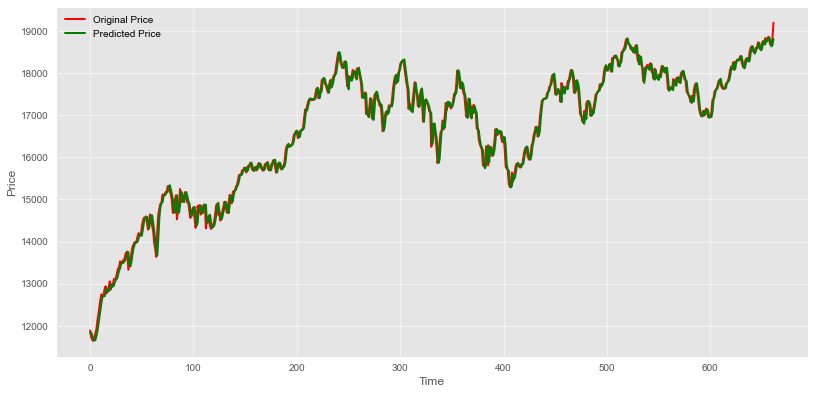

In [525]:
plt.figure(figsize=(12,6))
plt.plot(y_test,'r', label='Original Price')
plt.plot(y_pred,'g', label='Predicted Price')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

In [332]:
# #PLotting loss, it shows that loss has decreased significantly and model trained well
# loss = model.history.history['loss']
# plt.plot(loss)

In [333]:
print(f"Accuracy:-{r2_score(y_pred,y_test)}")
rmse=np.sqrt(np.mean(y_pred-y_test)**2)
rmse

Accuracy:-0.9890101855036725


14.163465056174482

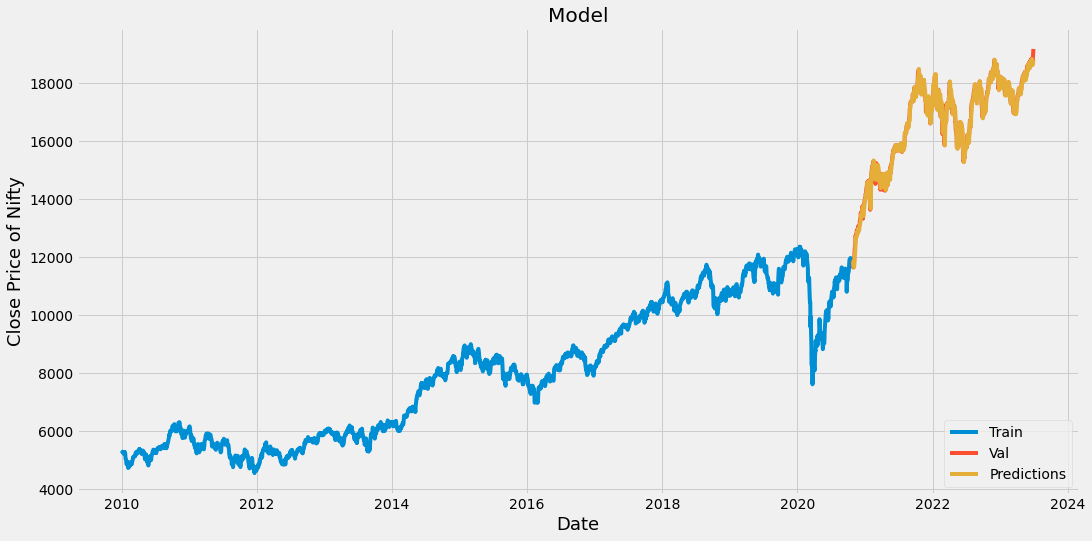

In [334]:
#Plot the data
train=close[:split_point].copy()
valid=close[split_point:].copy()
valid["Predictions"]=y_pred
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price of Nifty',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[["Close","Predictions"]])
plt.legend(['Train',"Val","Predictions"],loc="lower right")

In [335]:
start_date = datetime.datetime(2010, 1, 1)
# end_date = datetime.datetime(2023,6,21)
end_date = datetime.datetime.today()
ticker = "^NSEI"  # Ticker symbol for the Nifty index
data2 = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [337]:
new_df=data2.filter(['Close'])
last_100_days=new_df[-100:].values

# Load the scaler object from the file
# with open('scaler.pkl', 'rb') as f:
#     scaler = pickle.load(f)
    
last_100_days=scaler.fit_transform(last_100_days)
# print((last_100_days))
X_test=[]
X_test.append(last_100_days)
print(type(X_test))
X_test=np.array(X_test)
# print((X_test))

<class 'list'>


In [338]:
X_test.shape

(1, 100, 1)

In [339]:
Y_pred=model.predict(X_test)
Y_pred=scaler.inverse_transform(Y_pred)
print(Y_pred)

1/1 [==============================] - 0s 34ms/step
[[19195.543]]


In [340]:
test_data[-100:].shape

(100, 1)

In [482]:
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime.today()

ticker = "^NSEI"  # Ticker symbol for the Nifty index
data3= yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [483]:
df_close=data3.filter(['Close'])
df_close=df_close.values
df_close[-10:]

array([[18688.09960938],
       [18826.        ],
       [18755.44921875],
       [18816.69921875],
       [18856.84960938],
       [18771.25      ],
       [18665.5       ],
       [18691.19921875],
       [18817.40039062],
       [19189.05078125]])

In [484]:
df_close_scaled=scaler.fit_transform(df_close)
df_close_scaled[-10:]

array([[0.96579336],
       [0.97520966],
       [0.97039222],
       [0.97457457],
       [0.97731618],
       [0.97147115],
       [0.96425018],
       [0.96600501],
       [0.97462245],
       [1.        ]])

In [485]:
print(df_close_scaled[-100:].shape)

(100, 1)


In [499]:
fut_inp=df_close_scaled[-100:]
fut_inp=fut_inp.reshape(1,-1)
tem_inp = list(fut_inp)
print(fut_inp.shape)
tem_inp=tem_inp[0].tolist()

(1, 100)


In [507]:

lst_output = []
n_steps = 100
i=0
while(i<100):

    if len(tem_inp) > 100:
        fut_inp = np.array(tem_inp[1:])
        fut_inp = fut_inp.reshape(1, -1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tem_inp.extend(yhat[0].tolist())
        tem_inp = tem_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1

    else:
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tem_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

print(lst_output)


[[0.8200658559799194], [0.8194795846939087], [0.8189622759819031], [0.8185053467750549], [0.8181017637252808], [0.8177448511123657], [0.8174281120300293], [0.8171457648277283], [0.816892683506012], [0.8166640996932983], [0.8164558410644531], [0.8162640333175659], [0.8160855770111084], [0.8159172534942627], [0.8157569766044617], [0.8156023025512695], [0.8154517412185669], [0.8153035640716553], [0.8151564598083496], [0.8150097131729126], [0.8148621916770935], [0.8147134780883789], [0.8145632743835449], [0.8144112229347229], [0.8142573833465576], [0.8141014575958252], [0.8139435052871704], [0.8137838840484619], [0.8136226534843445], [0.8134599924087524], [0.8132962584495544], [0.8131316900253296], [0.8129667043685913], [0.8128014802932739], [0.8126363754272461], [0.8124719858169556], [0.8123080134391785], [0.8121451735496521], [0.8119835257530212], [0.8118234872817993], [0.8116652965545654], [0.8115090727806091], [0.8113548159599304], [0.8112029433250427], [0.8110536932945251], [0.8109070

In [508]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,101+len(lst_output))

In [509]:
len(df_close_scaled)

3310

In [510]:
df_close_scaled[-100:-100+5]

array([[0.8926073 ],
       [0.8922044 ],
       [0.90884168],
       [0.90273365],
       [0.89979066]])

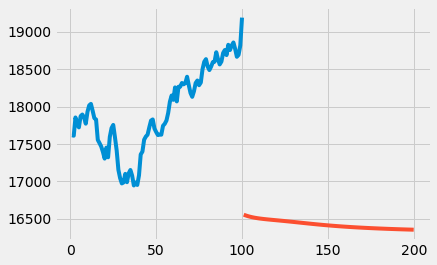

In [511]:
# lst_output = np.array(lst_output).reshape(-1, 1)
plt.plot(plot_new, scaler.inverse_transform(df_close_scaled[-100:]))
plt.plot(plot_pred, scaler.inverse_transform(lst_output))

In [512]:
# lst_output

In [513]:
len(lst_output)

100

In [514]:
# plt.plot( scaler.inverse_transform(df_close_scaled[3210:]))
# plt.plot(scaler.inverse_transform(lst_output))

In [515]:
df_new=df_close_scaled.tolist()
len(df_new)

3310

3410


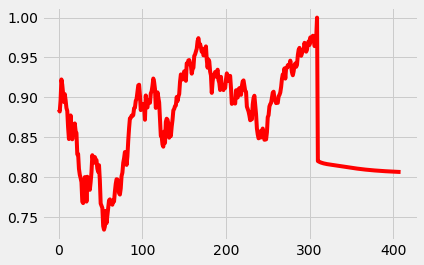

In [516]:
# Extends helps us to fill the missing value with approx value
df_new.extend(lst_output)
print(len(df_new))
plt.plot(df_new[3000:],'r')

In [517]:
len(df_new)

3410

In [518]:
#Creating final data for plotting
final_graph = scaler.inverse_transform(df_new).tolist()


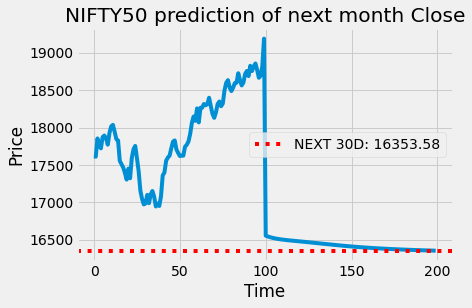

In [519]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph[-200:])
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month Close".format('NIFTY50'))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()